# Medical Insurance Cost Prediction — Model Comparison Study

## Project Overview

The objective of this notebook is to develop an end-to-end machine learning solution for predicting **medical insurance costs** based on demographic and lifestyle attributes such as age, BMI, smoking status, region, and number of dependents.

This notebook consolidates the **entire modeling workflow** into a single, coherent analysis, covering:
- Exploratory Data Analysis (EDA)
- Feature engineering and preprocessing
- Baseline and advanced regression models
- Model evaluation and comparison
- Final model selection based on performance and generalization

Multiple regression approaches are implemented and compared, including:
- Linear Regression
- Ridge Regression
- Support Vector Regression (SVR)
- Decision Tree Regression
- Random Forest Regression
- XGBoost Regression

Each model is evaluated using standard regression performance metrics, and their strengths and limitations are analyzed.  
The notebook concludes with a comparative assessment to identify the model that best balances **predictive performance**, **robustness**, and **interpretability**.

This structured approach demonstrates the full machine learning lifecycle, from data understanding to model selection, in a manner suitable for real-world and production-oriented use cases.



## Dataset Description
Typical variables in this dataset include:
- **age**: Age of primary beneficiary  
- **sex**: Gender of the insurance contractor  
- **bmi**: Body Mass Index  
- **children**: Number of dependents  
- **smoker**: Smoking status  
- **region**: Residential region  
- **charges**: Medical insurance cost (Target Variable)

## 1. Importing Dependencies and Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

plt.rcParams['figure.figsize'] = (8, 5)
sns.set_style("whitegrid")

## 2. Dataset Loading and Initial Inspection

The insurance dataset contains demographic, lifestyle, and regional attributes of individuals along with their corresponding medical insurance charges.  
Initial inspection is performed to understand the structure, data types, and completeness of the dataset.

In [2]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.shape

(1338, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [5]:
df.nunique()

age           47
sex            2
bmi          548
children       6
smoker         2
region         4
charges     1337
dtype: int64

In [6]:
df.region.value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

In [7]:
df.sex.value_counts()

sex
male      676
female    662
Name: count, dtype: int64

In [8]:
df.smoker.value_counts()

smoker
no     1064
yes     274
Name: count, dtype: int64

In [9]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Distribution of Charges

Text(0.5, 1.0, 'Distribution Of Medical Insurance Charges')

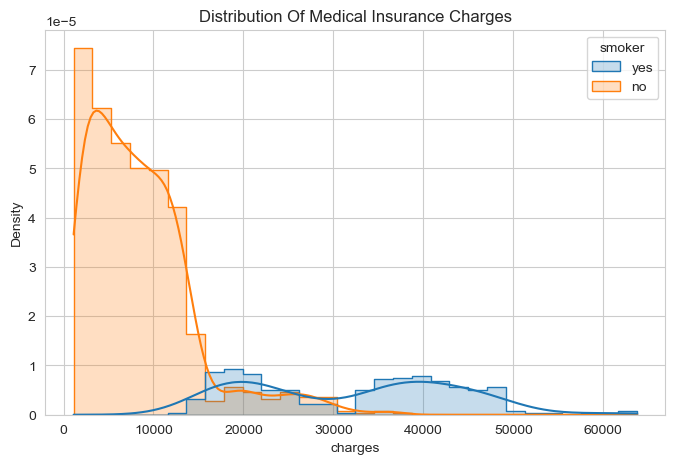

In [10]:
sns.histplot(
    data=df,
    x='charges',
    kde=True,
    hue='smoker',
    stat='density',
    element='step'
)
plt.title("Distribution Of Medical Insurance Charges")

## 3. Target Variable Transformation

**Why Log Transformation?**

Medical insurance charges typically exhibit:

- Strong **right skewness**
- **Heteroscedasticity** (variance increases with mean)

A log transformation:

- Stabilizes variance
- Improves linearity
- Makes residuals closer to normal (important for linear models)

We create a new transformed target:

> **`log(charges)`**

In [11]:
df['log_charges'] = np.log(df['charges'])
df[['charges', 'log_charges']].head()

,charges,log_charges
0,16884.92400,9.734176
1,1725.55230,7.453302
2,4449.46200,8.400538
3,21984.47061,9.998092
4,3866.85520,8.260197


In [12]:
df[['charges', 'log_charges']].describe()

,charges,log_charges
count,1338.000000,1338.000000
mean,13270.422265,9.098659
std,12110.011237,0.919527
min,1121.873900,7.022756
25%,4740.287150,8.463853
50%,9382.033000,9.146552
75%,16639.912515,9.719558
max,63770.428010,11.063045



### Key Observations
- **Charges** are highly skewed with extreme outliers  
- **Log-charges** exhibit a more symmetric distribution  
- Mean and median are closer after log transformation  

This suggests **log(charges)** is more suitable for:
- Linear Regression  
- Regularized models  
- Statistical inference


### 4(a). Distribution of Charges vs Smoker

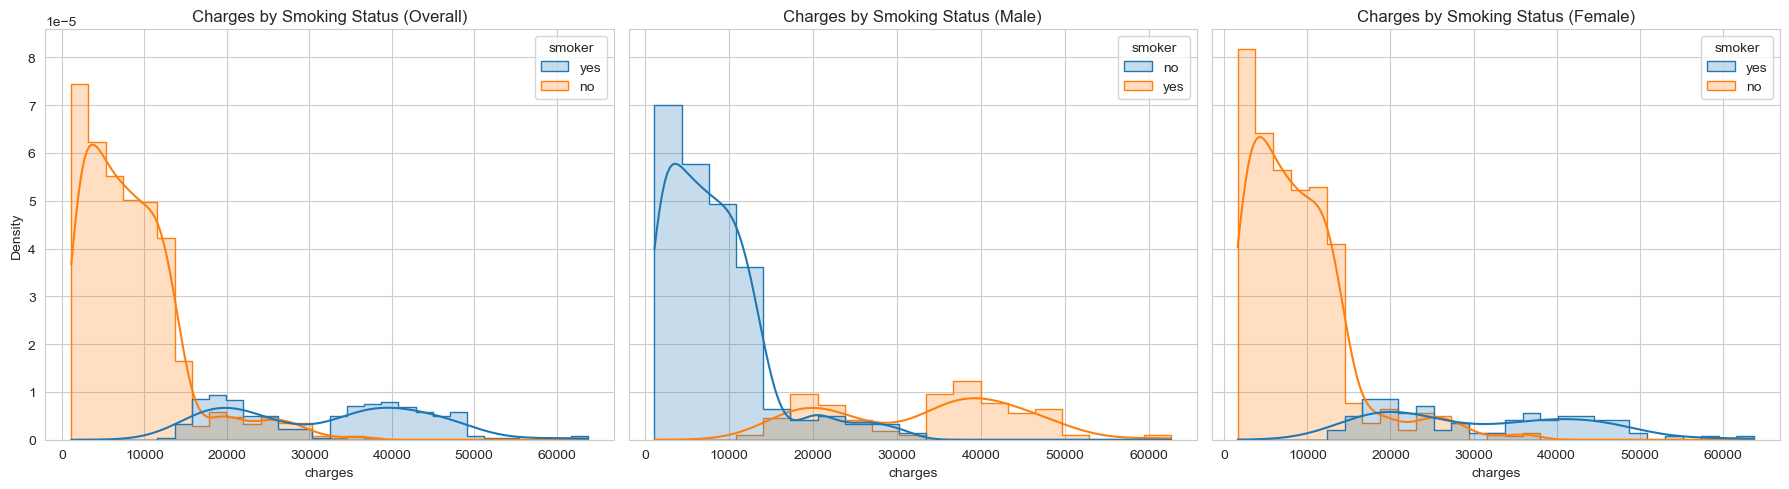

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Overall
sns.histplot(
    data=df, 
    x='charges',
    kde=True, 
    hue='smoker',
    element='step',
    stat='density',
    ax=axes[0]
)
axes[0].set_title('Charges by Smoking Status (Overall)')

# Male only
sns.histplot(
    data=df[df.sex == 'male'], 
    x='charges',
    kde=True, 
    hue='smoker',
    element='step', 
    stat='density',
    ax=axes[1]
)
axes[1].set_title('Charges by Smoking Status (Male)')

# Female only
sns.histplot(
    data=df[df.sex == 'female'], 
    x='charges',
    kde=True,
    hue='smoker',
    element='step',
    stat='density',
    ax=axes[2]
)
axes[2].set_title('Charges by Smoking Status (Female)')

plt.tight_layout()
plt.show()

### 4(b). Distribution of Log Charges vs Smoker

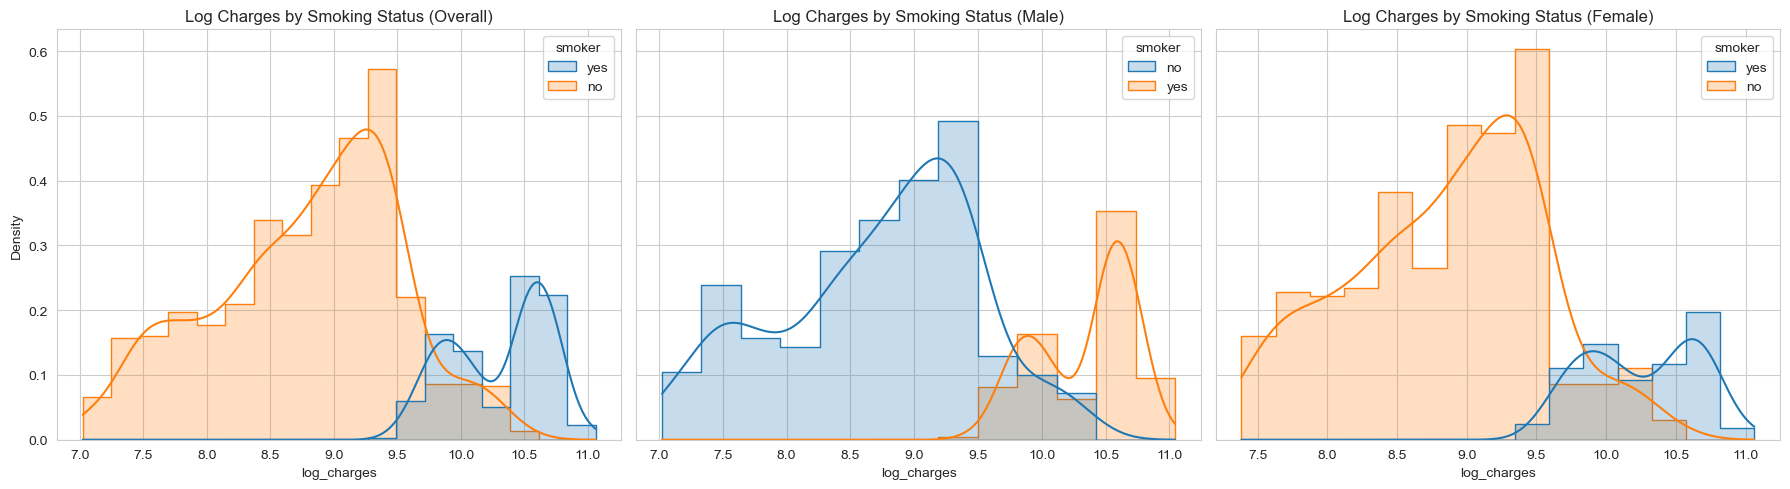

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# Overall
sns.histplot(
    data=df,
    x='log_charges',
    kde=True,
    hue='smoker',
    element='step',
    stat='density',
    ax=axes[0]
)
axes[0].set_title('Log Charges by Smoking Status (Overall)')

# Male only
sns.histplot(
    data=df[df.sex == 'male'],
    x='log_charges',
    kde=True,
    hue='smoker',
    element='step',
    stat='density',
    ax=axes[1]
)
axes[1].set_title('Log Charges by Smoking Status (Male)')

# Female only
sns.histplot(
    data=df[df.sex == 'female'],
    x='log_charges',
    kde=True,
    hue='smoker',
    element='step',
    stat='density',
    ax=axes[2]
)
axes[2].set_title('Log Charges by Smoking Status (Female)')

plt.tight_layout()
plt.show()


## 5. Correlation Analysis

In [15]:
# Select relevant columns
df_corr = df.copy()

In [16]:
# One-hot encoding categorical variables
df_corr_encoded = pd.get_dummies(
    df_corr,
    columns=['sex', 'smoker', 'region'],
    drop_first=True
)

In [17]:
# Correlation matrix
corr_matrix = df_corr_encoded.corr()
corr_matrix

,age,bmi,children,charges,log_charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
age,1.000000,0.109272,0.042469,0.299008,0.527834,-0.020856,-0.025019,-0.000407,-0.011642,0.010016
bmi,0.109272,1.000000,0.012759,0.198341,0.132669,0.046371,0.003750,-0.135996,0.270025,-0.006205
children,0.042469,0.012759,1.000000,0.067998,0.161336,0.017163,0.007673,0.024806,-0.023066,0.021914
charges,0.299008,0.198341,0.067998,1.000000,0.892964,0.057292,0.787251,-0.039905,0.073982,-0.043210
log_charges,0.527834,0.132669,0.161336,0.892964,1.000000,0.005632,0.665506,-0.017824,0.015791,-0.041632
sex_male,-0.020856,0.046371,0.017163,0.057292,0.005632,1.000000,0.076185,-0.011156,0.017117,-0.004184
smoker_yes,-0.025019,0.003750,0.007673,0.787251,0.665506,0.076185,1.000000,-0.036945,0.068498,-0.036945
region_northwest,-0.000407,-0.135996,0.024806,-0.039905,-0.017824,-0.011156,-0.036945,1.000000,-0.346265,-0.320829
region_southeast,-0.011642,0.270025,-0.023066,0.073982,0.015791,0.017117,0.068498,-0.346265,1.000000,-0.346265
region_southwest,0.010016,-0.006205,0.021914,-0.043210,-0.041632,-0.004184,-0.036945,-0.320829,-0.346265,1.000000


### Correlation Heatmap

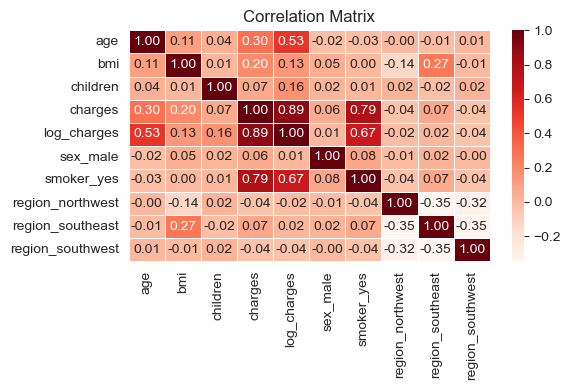

In [18]:
plt.figure(figsize=(6, 4))

sns.heatmap(
    corr_matrix,
    cmap='Reds',
    annot=True,
    fmt='.2f',
    linewidths=0.5
)

plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

## 6. Features and Targets

In [19]:
# Features
X = df.drop(['charges', 'log_charges'], axis=1)

# Target
y_log = df['log_charges']
y_raw = df['charges']

#### Categorical Feature Encoding

The dataset contains both numerical and categorical variables.  
Since machine learning models require numerical inputs, categorical variables must be encoded appropriately.

To avoid introducing artificial ordering and data leakage, categorical variables are encoded using **One-Hot Encoding** within a preprocessing pipeine.
.


In [20]:
# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target variables from numerical list
numerical_cols.remove('charges')
numerical_cols.remove('log_charges')

In [21]:
print("Categorical Features : ",categorical_cols)
print("Numerical Features : ", numerical_cols)

Categorical Features :  ['sex', 'smoker', 'region']
Numerical Features :  ['age', 'bmi', 'children']


## 7. Train-Test-Split

In [22]:
X_train, X_test, y_log_train, y_log_test = train_test_split(
    X, y_log, test_size=0.20, random_state=42
)

_, _, y_raw_train, y_raw_test = train_test_split(
    X, y_raw, test_size=0.20, random_state=42
)

## 8. Linear Regression

In [23]:
from sklearn.linear_model import LinearRegression

preprocessor_lr = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', MinMaxScaler(), numerical_cols)
    ]
)

lr_model = Pipeline(steps=[
    ('preprocessing', preprocessor_lr),
    ('regressor', LinearRegression())
])

lr_model.fit(X_train, y_log_train)

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Model Evaluation

In [24]:
y_pred = lr_model.predict(X_test)

r2 = r2_score(y_log_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_log_test, y_pred))

print(f"R2 Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R2 Score: 0.8047
RMSE: 0.4190


## 9. Ridge Regression

In [25]:
from sklearn.linear_model import Ridge

preprocessor_ridge = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', MinMaxScaler(), numerical_cols)
    ]
)

ridge_model = Pipeline(steps=[
    ('preprocessing', preprocessor_ridge),
    ('regressor', Ridge(alpha=0.1))
])

ridge_model.fit(X_train, y_log_train)

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [26]:
ridge_train_pred = ridge_model.predict(X_train)
ridge_test_pred  = ridge_model.predict(X_test)

print(f"Ridge Train R2: {r2_score(y_log_train, ridge_train_pred):.4f}")
print(f"Ridge Test  R2: {r2_score(y_log_test, ridge_test_pred):.4f}")
print(f"Ridge Test RMSE: {np.sqrt(mean_squared_error(y_log_test, ridge_test_pred)):.4f}")

Ridge Train R2: 0.7572
Ridge Test  R2: 0.8047
Ridge Test RMSE: 0.4191


## Ridge Hyperparameter Tuning

In [27]:
param_grid = {
    'regressor__alpha': [0.01, 0.1, 1, 10, 100]
}

ridge_gs = GridSearchCV(
    ridge_model,
    param_grid,
    cv=5,
    scoring='r2'
)

ridge_gs.fit(X_train, y_log_train)

,estimator,Pipeline(step...(alpha=0.1))])
,param_grid,"{'regressor__alpha': [0.01, 0.1, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...)]"


In [28]:
best_ridge = ridge_gs.best_estimator_

best_ridge_test_pred = best_ridge.predict(X_test)

print("Best Ridge Alpha:", ridge_gs.best_params_)
print(f"Best Ridge Test R2: {r2_score(y_log_test, best_ridge_test_pred):.4f}")
print(f"Best Ridge RMSE: {np.sqrt(mean_squared_error(y_log_test, best_ridge_test_pred)):.4f}")

Best Ridge Alpha: {'regressor__alpha': 1}
Best Ridge Test R2: 0.8042
Best Ridge RMSE: 0.4196


## 10. SVR

In [29]:
from sklearn.svm import SVR

preprocessor_svr = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ]
)

svr_model = Pipeline(steps=[
    ('preprocessing', preprocessor_svr),
    ('regressor', SVR(
        kernel='rbf',
        C=10,
        epsilon=0.1,
        gamma='scale'
    ))
])

In [30]:
svr_model.fit(X_train, y_log_train)

train_pred = svr_model.predict(X_train)
test_pred  = svr_model.predict(X_test)

print(f"SVR Train R2 Score: {r2_score(y_log_train, train_pred):.4f}")
print(f"SVR Test R2 Score: {r2_score(y_log_test, test_pred):.4f}")
print(f"SVR Test RMSE: {np.sqrt(mean_squared_error(y_log_test, test_pred)):.4f}")

SVR Train R2 Score: 0.8530
SVR Test R2 Score: 0.8535
SVR Test RMSE: 0.3629


## Hyperparameter Tuning

In [31]:
param_grid = {
    'regressor__C': [1, 10, 50],
    'regressor__epsilon': [0.05, 0.1, 0.2],
    'regressor__gamma': ['scale', 0.1, 0.01]
}

In [32]:
svr_gs = GridSearchCV(
    svr_model,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

svr_gs.fit(X_train, y_log_train)

,estimator,"Pipeline(step..., SVR(C=10))])"
,param_grid,"{'regressor__C': [1, 10, ...], 'regressor__epsilon': [0.05, 0.1, ...], 'regressor__gamma': ['scale', 0.1, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...)]"


In [33]:
best_svr = svr_gs.best_estimator_

best_svr_pred = best_svr.predict(X_test)

print(f"Best SVR Test R2: {r2_score(y_log_test, best_svr_pred):.4f}")
print(f"Best SVR Test RMSE: {np.sqrt(mean_squared_error(y_log_test, best_svr_pred)):.4f}")

Best SVR Test R2: 0.8619
Best SVR Test RMSE: 0.3523


## 11. Decision Tree Regressor

In [34]:
from sklearn.tree import DecisionTreeRegressor

preprocessor_dt = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'
)

dt_model = Pipeline(steps=[
    ('preprocessing', preprocessor_dt),
    ('regressor', DecisionTreeRegressor(
        max_depth=5,
        min_samples_leaf=20,
        random_state=42
    ))
])

dt_model.fit(X_train, y_log_train)

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [35]:
train_pred = dt_model.predict(X_train)
test_pred  = dt_model.predict(X_test)

print(f"Train R2 Score: {r2_score(y_log_train, train_pred):.4f}")
print(f"Test  R2 Score: {r2_score(y_log_test, test_pred):.4f}")
print(f"Test RMSE: {np.sqrt(mean_squared_error(y_log_test, test_pred)):.4f}")

Train R2 Score: 0.8395
Test  R2 Score: 0.8500
Test RMSE: 0.3672


## Hyperparameter Tuning

In [36]:
param_grid = {
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__min_samples_leaf': [5, 10, 20, 50]
}

dt_gs = GridSearchCV(
    dt_model,
    param_grid,
    cv=5,
    scoring='r2'
)

dt_gs.fit(X_train, y_log_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'regressor__max_depth': [3, 5, ...], 'regressor__min_samples_leaf': [5, 10, ...]}"
,scoring,'r2'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...)]"


In [37]:
best_dt = dt_gs.best_estimator_

In [38]:
from sklearn.model_selection import cross_val_score

max_depths = range(1, 16)

train_rmse = []
val_rmse = []

for depth in max_depths:
    
    dt_model = Pipeline(steps=[
        ('preprocessing', preprocessor_dt),
        ('regressor', DecisionTreeRegressor(
            max_depth=depth,
            min_samples_leaf=20,
            random_state=42
        ))
    ])
    
    # Training error
    dt_model.fit(X_train, y_log_train)
    train_pred = dt_model.predict(X_train)
    train_rmse.append(
        np.sqrt(mean_squared_error(y_log_train, train_pred))
    )
    
    # Validation error (cross-validation)
    cv_rmse = -cross_val_score(
        dt_model,
        X_train,
        y_log_train,
        cv=5,
        scoring='neg_root_mean_squared_error'
    ).mean()
    
    val_rmse.append(cv_rmse)

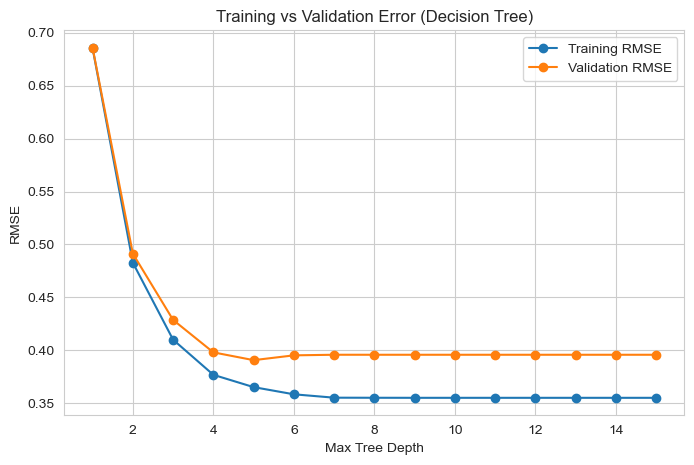

In [39]:
plt.figure(figsize=(8, 5))

plt.plot(max_depths, train_rmse, marker='o', label='Training RMSE')
plt.plot(max_depths, val_rmse, marker='o', label='Validation RMSE')

plt.xlabel('Max Tree Depth')
plt.ylabel('RMSE')
plt.title('Training vs Validation Error (Decision Tree)')
plt.legend()
plt.show()

## 12. Random Forest

In [40]:
from sklearn.ensemble import RandomForestRegressor

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
    ],
    remainder='passthrough'
)

rf_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        min_samples_leaf=10,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_raw_train)

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [41]:
train_pred = rf_model.predict(X_train)
test_pred  = rf_model.predict(X_test)

print(f"Random Forest Train R2: {r2_score(y_raw_train, train_pred):.4f}")
print(f"Random Forest Test  R2: {r2_score(y_raw_test, test_pred):.4f}")
print(f"Random Forest Test RMSE: {np.sqrt(mean_squared_error(y_raw_test, test_pred)):.4f}")

Random Forest Train R2: 0.8870
Random Forest Test  R2: 0.8778
Random Forest Test RMSE: 4355.3492


In [42]:
rf_gs = GridSearchCV(
    rf_model,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

rf_gs.fit(X_train, y_raw_train)

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'regressor__max_depth': [3, 5, ...], 'regressor__min_samples_leaf': [5, 10, ...]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...)]"


In [43]:
best_rf = rf_gs.best_estimator_

In [44]:
best_rf_pred = best_rf.predict(X_test)

print(f"Best RF Test R2: {r2_score(y_raw_test, best_rf_pred):.4f}")
print(f"Best RF Test RMSE: {np.sqrt(mean_squared_error(y_raw_test, best_rf_pred)):.4f}")

Best RF Test R2: 0.8737
Best RF Test RMSE: 4428.1893


In [45]:
# Extract feature names
cat_features = best_rf.named_steps['preprocessing'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(categorical_cols)

feature_names = list(cat_features) + numerical_cols

## 13. XGBoost Regressor

In [46]:
from xgboost import XGBRegressor

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder = 'passthrough'
)

xgb_model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    ))
])

xgb_model.fit(X_train, y_raw_train)

,steps,"[('preprocessing', ...), ('regressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [47]:
train_pred = xgb_model.predict(X_train)
test_pred  = xgb_model.predict(X_test)

print(f"XGBoost Train R2: {r2_score(y_raw_train, train_pred):.4f}")
print(f"XGBoost Test  R2: {r2_score(y_raw_test, test_pred):.4f}")
print(f"XGBoost Test RMSE: {np.sqrt(mean_squared_error(y_raw_test, test_pred)):.4f}")

XGBoost Train R2: 0.9790
XGBoost Test  R2: 0.8616
XGBoost Test RMSE: 4634.8483


In [48]:
param_grid = {
    'regressor__n_estimators': [200, 300],
    'regressor__max_depth': [4, 6, 8],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__subsample': [0.8, 1.0]
}

In [49]:
xgb_gs = GridSearchCV(
    xgb_model,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

xgb_gs.fit(X_train, y_raw_train)

,estimator,"Pipeline(step...=None, ...))])"
,param_grid,"{'regressor__learning_rate': [0.05, 0.1], 'regressor__max_depth': [4, 6, ...], 'regressor__n_estimators': [200, 300], 'regressor__subsample': [0.8, 1.0]}"
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...)]"


In [50]:
best_xgb = xgb_gs.best_estimator_
best_xgb_pred = best_xgb.predict(X_test)

print(f"Best XGB Test R²: {r2_score(y_raw_test, best_xgb_pred):.4f}")
print(f"Best XGB Test RMSE: {np.sqrt(mean_squared_error(y_raw_test, best_xgb_pred)):.4f}")

Best XGB Test R²: 0.8788
Best XGB Test RMSE: 4337.8189


In [51]:
cat_features = best_xgb.named_steps['preprocessing'] \
    .named_transformers_['cat'] \
    .get_feature_names_out(categorical_cols)

feature_names = list(cat_features) + numerical_cols

In [52]:
importances = best_xgb.named_steps['regressor'].feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
1,smoker_yes,0.913724
6,bmi,0.032865
5,age,0.025617
7,children,0.007772
3,region_southeast,0.006384
0,sex_male,0.005081
4,region_southwest,0.004586
2,region_northwest,0.003972
